# Create example plots that show methods

Each step from input NDVI to output phenology metrics

In [1]:
%matplotlib inline

import sys
import pickle
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import scipy.signal
from scipy import stats
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry

sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology import extract_peaks_troughs, phenometrics

%load_ext autoreload
%autoreload 2

## Analysis Parameters


In [2]:
# k = 'Alice Tableland'
k = 'Western Mallee'
# k='Simpson Desert'

ds_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc'

# ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/Ecoregions2017_modified.geojson'
# ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_regions_modified.geojson'
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'

var='SUB_NAME_7'
# var='REG_NAME_7'
# var='ECO_NAME'

## Open data

In [3]:
ds = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326')
ds = ds.rename({'AusENDVI_clim_MCD43A4':'NDVI'})
ds = ds['NDVI']

## Clip to a region

In [4]:
gdf = gpd.read_file(ecoregions_file)
gdf = gdf[gdf[var]==k]

In [5]:
#clip to ecoregion
geom = Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)
ds = ds.odc.mask(poly=geom)
ds = ds.dropna(dim='longitude', how='all').dropna(dim='latitude', how='all')

# #summarise into 1d timeseries
ds = ds.mean(['latitude', 'longitude'])

## Smoothing filters

In [6]:
#resample before we smooth
ds_smooth = ds.resample(time="2W").interpolate("linear")

# # Savitsky-Golay smoothing
ds_smooth = xr.apply_ufunc(
        scipy.signal.savgol_filter,
        ds_smooth,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=11,
            polyorder=3,
            deriv=0,
            mode='interp'),
        dask='parallelized'
    )


ds_trim = ds.sel(time=slice('2010','2014'))
ds_smooth_trim = ds_smooth.sel(time=slice('2010','2014'))

## Interpolation to daily

In [7]:
ds_trim = ds.sel(time=slice('2010','2014'))
ds_smooth_trim = ds_smooth.sel(time=slice('2010','2014'))

quad=ds_smooth_trim.dropna(dim='time', how='all').resample(time='1D').interpolate(kind='quadratic')

## Show peak/trough extraction

In [8]:
d={k:ds_smooth.dropna(dim='time', how='all').resample(time='1D').interpolate(kind='quadratic')}

In [9]:
peaks_troughs = extract_peaks_troughs(d,
                                    rolling=90,
                                    distance=90,
                                    prominence='auto',
                                    plateau_size=10,
                                     )

## Extract phenometrics 

<!-- import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def double_logistic_function(t, wNDVI, mNDVI, S, A, mS, mA):
    sigmoid1 = 1 / (1 + np.exp(-mS * (t - S)))
    sigmoid2 = 1 / (1 + np.exp(mA * (t - A)))
    seasonal_term = sigmoid1 + sigmoid2 - 1
    return wNDVI + (mNDVI - wNDVI) * seasonal_term

def weight_function(t, S, A, r):
    tr = 100 * (t - S) / (A - S)
    tr = np.clip(tr, 0, 100)
    return np.exp(-np.abs(r) / (1 + tr / 10))

def fit_curve(t, ndvi_observed):
    initial_guess = [np.min(ndvi_observed), np.max(ndvi_observed), np.mean(t), np.mean(t), 1, 1]
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, maxfev=10000)
    residuals = ndvi_observed - double_logistic_function(t, *params)
    weights = weight_function(t, params[2], params[3], residuals)
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, sigma=weights, maxfev=10000)
    return params

doys = ndvi_cycle.time.dt.dayofyear.values[2:]
doys_frac = doys/365
values = ndvi_cycle.values[2:]

##Fit the curve
parameters = fit_curve(doys_frac, values)

##Plot the observed NDVI values
plt.scatter(doys, values, label='Observed NDVI')

##Generate points for the fitted curve
t_fit = np.linspace(min(doys_frac), max(doys_frac), 365)
ndvi_fit = double_logistic_function(t_fit, *parameters)

##Plot the fitted curve
plt.plot(t_fit*365, ndvi_fit, label='Fitted Curve', color='red')

plt.xlabel('Day of the Year')
plt.ylabel('NDVI')
plt.legend()
plt.title('Double Logistic Curve Fitting for NDVI Observations')
plt.show() -->


<!-- def xr_count_peaks(ds, order=16):
    def _find_peaks(ds):
        peaks = scipy.signal.argrelextrema(ds, np.greater, order=order)
        # peaks = scipy.signal.find_peaks(ds, height=0.2, distance=order)
        return len(peaks[0])
    
    ds_n_peaks = xr.apply_ufunc(_find_peaks,
                              ds, 
                              input_core_dims=[['time']],
                              vectorize=True, 
                              dask='parallelized',
                              output_dtypes=[np.float32]
                             )

    return ds_n_peaks.rename('n_peaks')

%%time
n_peaks = xr_count_peaks(ds_smooth.sel(time=slice('2004-09', '2006-03'))) -->

In [10]:
d={k:ds_smooth.dropna(dim='time', how='all').resample(time='1D').interpolate(kind='quadratic').sel(time=slice('2009','2022'))}
eco_regions_phenometrics = phenometrics(d,
                                        rolling=90,
                                        distance=90,
                                        prominence='auto',
                                        plateau_size=10,
                                        amplitude=0.20
                                       )

## Plot

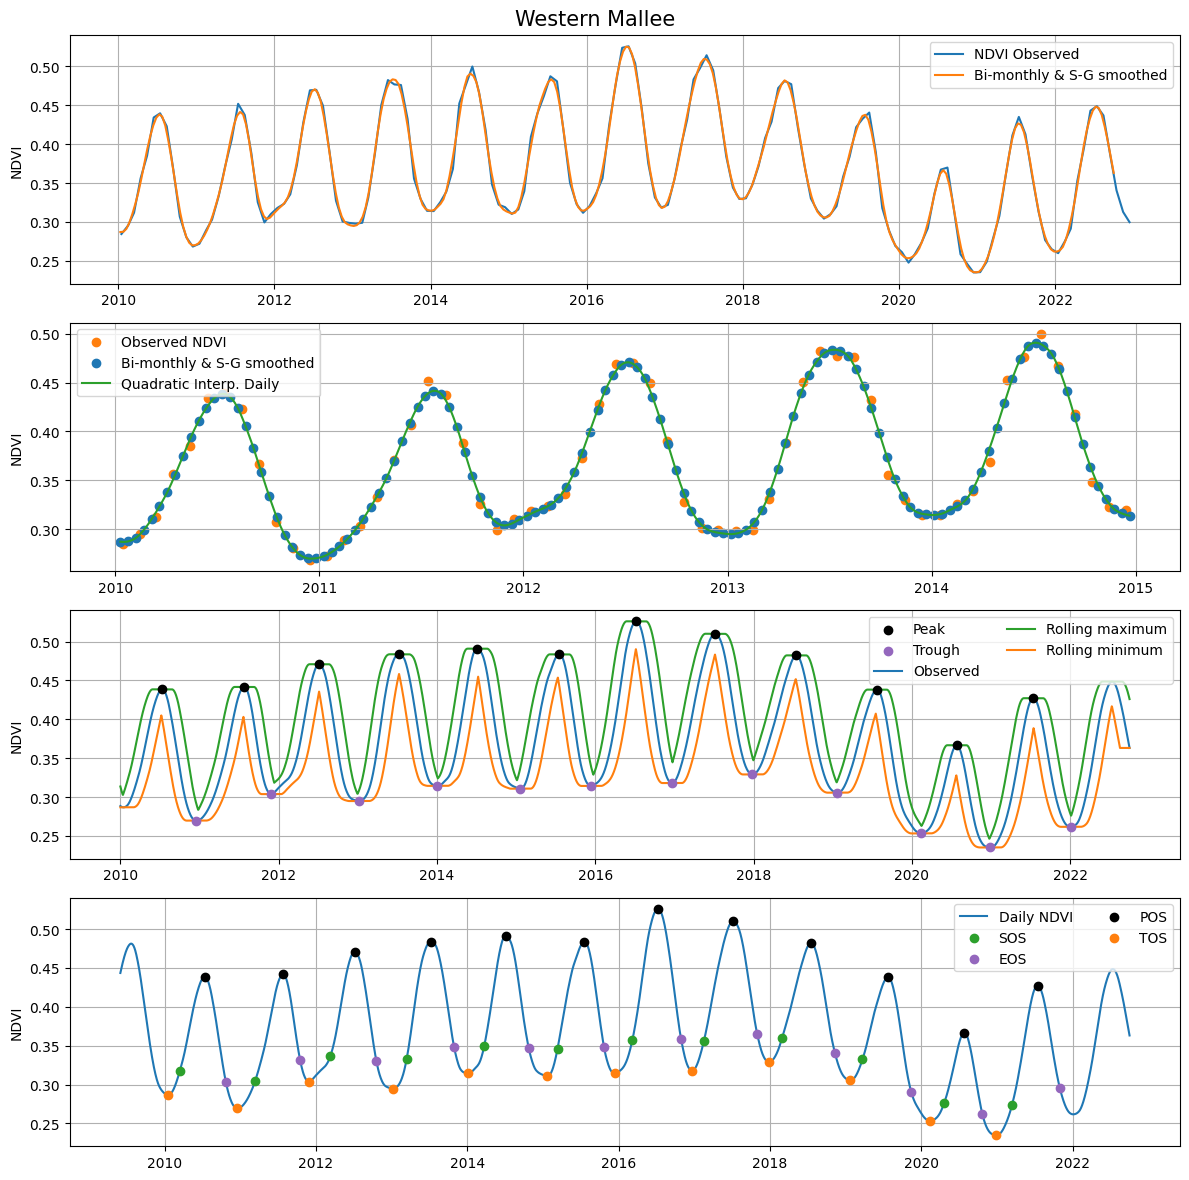

In [11]:
fig,ax=plt.subplots(4,1, figsize=(12,12))

ds.sel(time=slice('2010','2022')).plot(ax=ax[0], label='NDVI Observed')
ds_smooth.sel(time=slice('2010','2022')).plot(ax=ax[0], label='Bi-monthly & S-G smoothed')
ax[0].legend()
ax[0].grid()
ax[0].set_title(None)
ax[0].set_xlabel(None)

ax[1].scatter(ds_trim.time, ds_trim.values, label='Observed NDVI', color='tab:orange')
ax[1].scatter(ds_smooth_trim.time, ds_smooth_trim.values, label='Bi-monthly & S-G smoothed', color='tab:blue')
# plt.plot(t_fit*365, ndvi_fit, label='Double logistic curve', color='red')
ax[1].plot(quad.time, quad.values, label='Quadratic Interp. Daily', color='tab:green')
ax[1].set_xlabel(None)
ax[1].set_ylabel('NDVI')
ax[1].legend()
ax[1].set_title(None)
ax[1].grid()

ax[2].scatter(peaks_troughs[k].index[-25:-1],  peaks_troughs[k]['peaks'][-25:-1],  c='black', label='Peak', zorder=10);
ax[2].scatter(peaks_troughs[k].index[-25:-1],  peaks_troughs[k]['troughs'][-25:-1],  c='tab:purple', label='Trough', zorder=11);
d[k].sel(time=slice('2010','2022')).plot(ax=ax[2], label='Observed', c='tab:blue')
d[k].rolling(time=90, min_periods=1, center=True).max().sel(time=slice('2010','2022')).plot(ax=ax[2], label='Rolling maximum',c='tab:green')
d[k].rolling(time=90, min_periods=1, center=True).min().sel(time=slice('2010','2022')).plot(ax=ax[2], label='Rolling minimum', c='tab:orange')
ax[2].legend(ncols=2)
ax[2].grid()
ax[2].set_title(None)
ax[2].set_xlabel(None)

d[k].sel(time=slice('2009-06','2022')).plot(ax=ax[3], color='tab:blue', label='Daily NDVI')
ax[3].scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].SOS.values, eco_regions_phenometrics[k].SOS_year.values)],
           y=eco_regions_phenometrics[k].vSOS,
          c='tab:green', label='SOS', zorder=10)

ax[3].scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].EOS.values, eco_regions_phenometrics[k].EOS_year.values)],
           y=eco_regions_phenometrics[k].vEOS,
          c='tab:purple', label='EOS', zorder=10)

ax[3].scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].POS.values, eco_regions_phenometrics[k].POS_year.values)],
               y=eco_regions_phenometrics[k].vPOS,
              c='black', label='POS', zorder=10)
    
ax[3].scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].TOS.values, eco_regions_phenometrics[k].TOS_year.values)],
           y=eco_regions_phenometrics[k].vTOS,
          c='tab:orange', label='TOS', zorder=10)

ax[3].set_xlabel(None)
ax[3].set_ylabel('NDVI')
ax[3].legend(ncols=2)
ax[3].grid()
ax[3].set_title(None)
plt.suptitle(k, fontsize=15)
plt.tight_layout();

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/demonstrate_methods_{k}.png',
            bbox_inches='tight', dpi=300)

## Apply to flux tower GPP

In [ ]:
import sys
sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology_pixel import xr_phenometrics

In [99]:
r = 'Yanco'
phen = xr_phenometrics(flux_tss[r], prominence=1).compute()

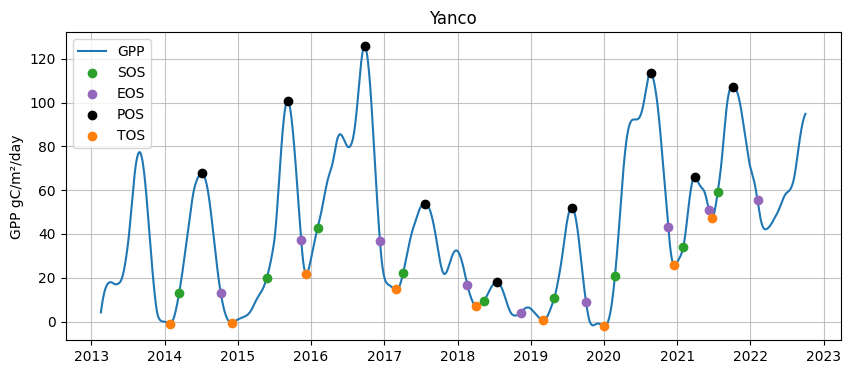

In [100]:
fig,ax=plt.subplots(1,1, figsize=(10,4))

flux_tss[r].plot(ax=ax, label='GPP')
ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(phen.SOS.values[0][0], phen.SOS_year.values[0][0])],
           y=phen.vSOS,
          c='tab:green', label='SOS', zorder=10)

ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(phen.EOS.values[0][0], phen.EOS_year.values[0][0])],
           y=phen.vEOS,
          c='tab:purple', label='EOS', zorder=10)

ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(phen.POS.values[0][0], phen.POS_year.values[0][0])],
               y=phen.vPOS,
              c='black', label='POS', zorder=10)
    
ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(phen.TOS.values[0][0], phen.TOS_year.values[0][0])],
           y=phen.vTOS,
          c='tab:orange', label='TOS', zorder=10);
ax.set_title(r);
ax.set_ylabel('GPP gC/m\N{SUPERSCRIPT TWO}/day')
ax.set_xlabel(None)
ax.grid(alpha=0.75)
ax.legend();